In [ ]:
!pip install torch pandas scikit-learn matplotlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib

In [ ]:
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
# Expected: CUDA available: True, GPU: Tesla T4
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Using Device: cuda


In [ ]:
!wget -q "https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip" -O CMAPSSData.zip

In [ ]:
!unzip -q CMAPSSData.zip -d data/

In [ ]:
!unzip "data/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip"

Archive:  data/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt           
  inflating: RUL_FD004.txt           
  inflating: test_FD001.txt          
  inflating: test_FD002.txt          
  inflating: test_FD003.txt          
  inflating: test_FD004.txt          
  inflating: train_FD001.txt         
  inflating: train_FD002.txt         
  inflating: train_FD003.txt         
  inflating: train_FD004.txt         


In [ ]:
!mv *.txt data/

In [ ]:
def load_and_masquerade_data(filepath):
    """
    Loads NASA data and renames columns to CFM LEAP parameter tags.
    """
    # 1. Define Standard NASA Column Names
    columns = ['unit', 'time', 'os1', 'os2', 'os3'] + [f's{i}' for i in range(1, 22)]

    # 2. Load Data
    df = pd.read_csv(filepath, sep=r'\s+', header=None, names=columns)

    # 3. Rename columns
    mapping = {
        's2': 'T25_LPC_Temp', 's3': 'T3_HPC_Temp', 's4': 'T49_EGT',
        's7': 'P3_HPC_Pressure', 's8': 'N1_Fan_RPM', 's9': 'N2_Core_RPM',
        's14': 'N2_Corrected', 's11': 'P49_LPT_Pressure', 's12': 'N1_Actual'
    }
    df = df.rename(columns=mapping)

    # 4. Synthetic Injection
    np.random.seed(42)
    noise_vib = np.random.normal(loc=0.5, scale=0.1, size=len(df))
    df['N1_Vib_Units'] = (df['N1_Fan_RPM'] / 5000) + noise_vib + (df['time'] * 0.0005)
    df['Oil_Pressure_PSI'] = (df['N2_Core_RPM'] / 200) + np.random.normal(15, 2, len(df))

    # 5. Select Features
    features = ['unit', 'time', 'T25_LPC_Temp', 'T3_HPC_Temp', 'T49_EGT',
                'P3_HPC_Pressure', 'N1_Fan_RPM', 'N2_Core_RPM',
                'N1_Vib_Units', 'Oil_Pressure_PSI']

    return df[features]

df = load_and_masquerade_data('data/train_FD001.txt')
print(f"Data Loaded. Shape: {df.shape}")

Data Loaded. Shape: (20631, 10)


Exploratory Data Analysis (EDA)

In [ ]:
df.head()

,unit,time,T25_LPC_Temp,T3_HPC_Temp,T49_EGT,P3_HPC_Pressure,N1_Fan_RPM,N2_Core_RPM,N1_Vib_Units,Oil_Pressure_PSI
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,1.027783,59.323183
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,0.964782,58.421604
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,1.043885,61.485189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,1.131925,63.462635
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,0.956697,61.108543


Preprocessing (To Tensors)
PyTorch requires data to be converted into torch.Tensor objects.

In [ ]:
# @title 2. Preprocessing & Tensor Conversion
from sklearn.preprocessing import MinMaxScaler

# 1. Split Training vs Testing (First 50 cycles = Healthy)
HEALTHY_CYCLES = 50
train_df = df[df['time'] <= HEALTHY_CYCLES]
test_df = df[df['time'] > HEALTHY_CYCLES]

# 2. Normalize Data
sensor_cols = ['T25_LPC_Temp', 'T3_HPC_Temp', 'T49_EGT', 'P3_HPC_Pressure',
               'N1_Fan_RPM', 'N2_Core_RPM', 'N1_Vib_Units', 'Oil_Pressure_PSI']

scaler = MinMaxScaler()
scaler.fit(train_df[sensor_cols])

train_scaled = scaler.transform(train_df[sensor_cols])
test_scaled = scaler.transform(test_df[sensor_cols])

# 3. Create Sequences
TIME_STEPS = 10

def create_sequences(data, time_steps=TIME_STEPS):
    output = []
    for i in range(len(data) - time_steps + 1):
        output.append(data[i : i + time_steps])
    return np.array(output)

X_train_np = create_sequences(train_scaled)
X_test_np = create_sequences(test_scaled)

# 4. Convert to PyTorch Tensors
# Note: PyTorch uses float32 by default for weights
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)

# 5. Create DataLoader for Batching
batch_size = 32
train_dataset = TensorDataset(X_train, X_train) # Target = Input (Autoencoder)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training Tensor Shape: {X_train.shape}")
print(f"Testing Tensor Shape: {X_test.shape}")

Training Tensor Shape: torch.Size([4991, 10, 8])
Testing Tensor Shape: torch.Size([15622, 10, 8])


The PyTorch Model (LSTM Autoencoder)

In [ ]:
# @title 3. Define PyTorch LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_dim=64, latent_dim=32, seq_len=10):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        # Encoder: Compresses the time series
        # batch_first=True means input is (Batch, Seq, Features)
        self.encoder1 = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
        self.encoder2 = nn.LSTM(input_size=hidden_dim, hidden_size=latent_dim, batch_first=True)

        # Decoder: Reconstructs the time series
        self.decoder1 = nn.LSTM(input_size=latent_dim, hidden_size=latent_dim, batch_first=True)
        self.decoder2 = nn.LSTM(input_size=latent_dim, hidden_size=hidden_dim, batch_first=True)

        # Output Layer: Maps back to original feature space
        self.output_layer = nn.Linear(hidden_dim, n_features)

    def forward(self, x):
        # --- ENCODER ---
        x, (_, _) = self.encoder1(x)

        # We only need the hidden state of the LAST time step from the encoder
        _, (hidden, _) = self.encoder2(x)
        # hidden shape: (1, Batch, Latent) -> squeeze to (Batch, Latent)
        latent = hidden[-1]

        # --- BRIDGE (RepeatVector) ---
        # Repeat the latent vector to match sequence length: (Batch, Seq, Latent)
        x_repeated = latent.unsqueeze(1).repeat(1, self.seq_len, 1)

        # --- DECODER ---
        x, (_, _) = self.decoder1(x_repeated)
        x, (_, _) = self.decoder2(x)

        # --- OUTPUT ---
        # Apply Linear layer to each time step
        reconstructed = self.output_layer(x)

        return reconstructed

# Initialize Model
n_features = X_train.shape[2]
model = LSTMAutoencoder(n_features, seq_len=TIME_STEPS).to(device)
print(model)

LSTMAutoencoder(
  (encoder1): LSTM(8, 64, batch_first=True)
  (encoder2): LSTM(64, 32, batch_first=True)
  (decoder1): LSTM(32, 32, batch_first=True)
  (decoder2): LSTM(32, 64, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=8, bias=True)
)


### Training Loop
PyTorch requires writing the training steps manually. This gives us full control.

Starting Training...
Epoch [5/50], Loss: 0.013905
Epoch [10/50], Loss: 0.013585
Epoch [15/50], Loss: 0.013016
Epoch [20/50], Loss: 0.012495
Epoch [25/50], Loss: 0.012076
Epoch [30/50], Loss: 0.011682
Epoch [35/50], Loss: 0.011412
Epoch [40/50], Loss: 0.011212
Epoch [45/50], Loss: 0.010766
Epoch [50/50], Loss: 0.010430


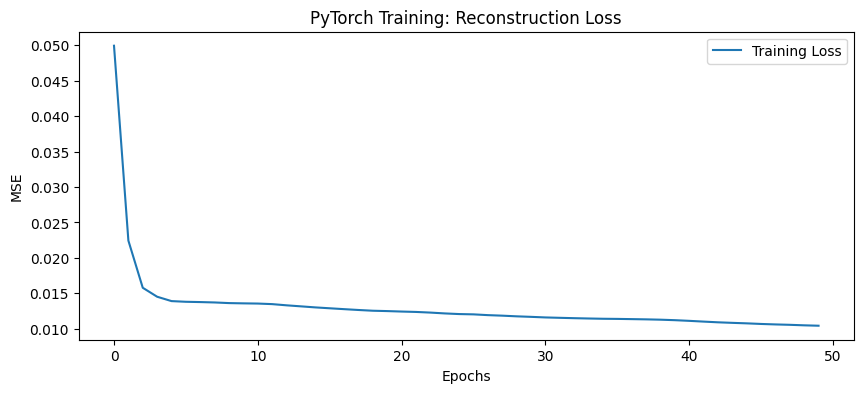

In [ ]:
# @title 4. Training Loop
# Hyperparameters
epochs = 50
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = {'loss': []}

print("Starting Training...")
model.train() # Set model to training mode

for epoch in range(epochs):
    epoch_loss = 0.0

    for batch_data, batch_target in train_loader:
        # 1. Zero Gradients
        optimizer.zero_grad()

        # 2. Forward Pass
        outputs = model(batch_data)

        # 3. Calculate Loss
        loss = criterion(outputs, batch_target)

        # 4. Backward Pass & Optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    history['loss'].append(avg_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(history['loss'], label='Training Loss')
plt.title('PyTorch Training: Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Anomaly Detection
Switch model to eval() mode for inference.



In [ ]:
# @title 5. Detect Anomalies
model.eval() # Set to evaluation mode (disable dropout, etc.)

# 1. Predict on Test Data (No Gradient Calculation needed)
with torch.no_grad():
    X_test_pred_tensor = model(X_test)
    X_train_pred_tensor = model(X_train)

# Convert back to Numpy for easy calculation
X_test_pred = X_test_pred_tensor.cpu().numpy()
X_test_real = X_test.cpu().numpy()

X_train_pred = X_train_pred_tensor.cpu().numpy()
X_train_real = X_train.cpu().numpy()

# 2. Calculate Mean Absolute Error (MAE)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test_real), axis=1) # (Batch, Features)
test_mae_avg = np.mean(test_mae_loss, axis=1) # Average over features

# 3. Define Threshold (Max of Training Loss)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_real), axis=1)
train_mae_avg = np.mean(train_mae_loss, axis=1)

THRESHOLD = np.max(train_mae_avg) * 1.05 # 5% Safety Buffer
print(f"Anomaly Threshold: {THRESHOLD:.4f}")

# 4. Create Results DataFrame
test_score_df = pd.DataFrame(test_df[TIME_STEPS-1:]) # Align rows
test_score_df['loss'] = test_mae_avg
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']

print(f"Anomalies Detected: {test_score_df['anomaly'].sum()} sequences")

Anomaly Threshold: 0.1216
Anomalies Detected: 2265 sequences


### Visualization
Standard Matplotlib

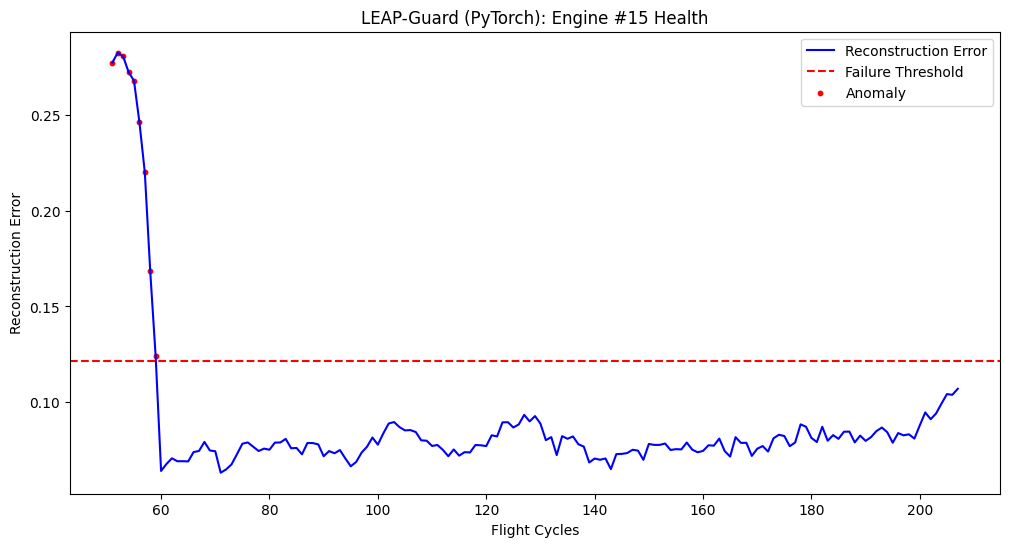

In [ ]:
# @title 6. Visualize Engine Health
subset = test_score_df[test_score_df['unit'] == 15]

plt.figure(figsize=(12, 6))
plt.plot(subset['time'], subset['loss'], label='Reconstruction Error', color='blue')
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label='Failure Threshold')

# Highlight Anomalies
anomalies = subset[subset['anomaly'] == True]
plt.scatter(anomalies['time'], anomalies['loss'], color='red', s=10, label='Anomaly')

plt.title('LEAP-Guard (PyTorch): Engine #15 Health')
plt.xlabel('Flight Cycles')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

### Export Model (PyTorch Format)
PyTorch saves the "State Dictionary" (Weights).

In [ ]:
# @title 7. Save Artifacts
# 1. Save PyTorch Model Weights
torch.save(model.state_dict(), 'leap_guard_model.pth')

# 2. Save Scaler
joblib.dump(scaler, 'leap_guard_scaler.pkl')

# 3. Save Test Data for App
sample_data = test_df[test_df['unit'] == 15].to_dict(orient='records')
import json
with open('test_engine_15.json', 'w') as f:
    json.dump(sample_data, f)

print("Saved: leap_guard_model.pth, leap_guard_scaler.pkl, test_engine_15.json")

Saved: leap_guard_model.pth, leap_guard_scaler.pkl, test_engine_15.json


### Generate Deployment Configuration
Run this after training and threshold calculation.

In [ ]:
# @title 8. Generate Production Config Files
import json

# 1. Prepare Threshold File
# Convert numpy float to python float for JSON serialization
threshold_data = {
    "threshold_mae": float(THRESHOLD),
    "description": "Calculated as Max MAE of Training Data + 5% buffer"
}

with open('threshold.json', 'w') as f:
    json.dump(threshold_data, f, indent=4)


# 2. Prepare Config File
# Extract column names directly from the dataframe to ensure exact order match
feature_order = df.columns.tolist()

# You might want to remove 'unit' and 'time' if your model doesn't strictly use them
# (In our previous cell, we used them for plotting, but scaled only sensors.
# Ideally, we list EXACTLY what the scaler expects).
# Let's get the exact columns the SCALER was fitted on:
scaler_features = [
    'T25_LPC_Temp', 'T3_HPC_Temp', 'T49_EGT',
    'P3_HPC_Pressure', 'N1_Fan_RPM', 'N2_Core_RPM',
    'N1_Vib_Units', 'Oil_Pressure_PSI'
]

config_data = {
    "model_name": "LEAP-Guard LSTM Autoencoder",
    "version": "1.0",
    "input_sequence_length": int(TIME_STEPS),
    "n_features": len(scaler_features),
    "feature_columns": scaler_features, # CRITICAL: The API must receive data in this order
    "sensor_mapping_display": {         # Helpful for Frontend Labels
        "T25_LPC_Temp": "LPC Outlet Temp (C)",
        "T49_EGT": "Exhaust Gas Temp (C)",
        "N1_Vib_Units": "Fan Vibration (Units)",
        "Oil_Pressure_PSI": "Oil Pressure (PSI)"
    }
}

with open('config.json', 'w') as f:
    json.dump(config_data, f, indent=4)

print("✅ Success! Generated:")
print("   - threshold.json (Anomaly logic)")
print("   - config.json (Pipeline rules)")

✅ Success! Generated:
   - threshold.json (Anomaly logic)
   - config.json (Pipeline rules)
